# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
# !pip install yahoo_fin
# !conda install -y -c conda-forge tensorflow

In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

from nsepy import get_history
from datetime import date
from nsetools import Nse

ModuleNotFoundError: No module named 'yahoo_fin'

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'SBIN'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
date_now

'2022-10-16'

In [5]:
_start = dt.date(2020,1,1)
_end = dt.date(2022,10,3)
ticker = 'SBIN'
init_df = get_history(ticker, start = _start, end = _end)

In [8]:
_start = dt.date(2022,9,30)
_end = dt.date(2022,10,10)
ticker = 'SBIN'
init_df_1 = get_history(ticker, start = _start, end = _end)

In [9]:
init_df_1

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2022-09-30,SBIN,EQ,521.75,524.0,536.90,516.15,531.55,530.60,528.17,17466950,9.225478e+14,199404,5533983,0.3168
2022-10-03,SBIN,EQ,530.60,527.6,531.65,518.50,518.95,519.75,525.01,9351162,4.909456e+14,141130,3430661,0.3669
2022-10-04,SBIN,EQ,519.75,533.0,535.80,527.80,532.95,532.70,532.39,8745887,4.656245e+14,128142,3456189,0.3952
2022-10-06,SBIN,EQ,532.70,534.6,541.80,534.60,537.35,537.30,538.44,9507322,5.119102e+14,183101,4430981,0.4661
2022-10-07,SBIN,EQ,537.30,535.5,535.60,526.55,531.00,530.20,529.64,11065307,5.860624e+14,185698,5018194,0.4535
2022-10-10,SBIN,EQ,530.20,525.7,533.90,522.20,531.40,530.75,528.13,9649292,5.096053e+14,191653,3588945,0.3719


In [10]:
# init_df

In [11]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
# init_df = yf.get_data(
#     STOCK, 
#     start_date=date_3_years_back, 
#     end_date=date_now, 
#     interval='1d')

In [12]:
init_df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2022-09-27,SBIN,EQ,543.30,544.55,550.90,533.20,538.00,536.50,542.40,11066799,6.002626e+14,154979,3097415,0.3404
2022-09-28,SBIN,EQ,536.50,532.90,539.80,520.35,523.50,524.85,532.17,12233485,6.510285e+14,183919,5224334,0.4271
2022-09-29,SBIN,EQ,524.85,529.00,535.70,519.55,524.00,521.75,525.18,17310168,9.090987e+14,215284,8111849,0.4686
2022-09-30,SBIN,EQ,521.75,524.00,536.90,516.15,531.55,530.60,528.17,17466950,9.225478e+14,199404,5533983,0.3168
2022-10-03,SBIN,EQ,530.60,527.60,531.65,518.50,518.95,519.75,525.01,9351162,4.909456e+14,141130,3430661,0.3669


In [13]:
# remove columns which our neural network will not use
# init_df = init_df.drop(['Open', 'High', 'Low', 'ticker', 'Volume'], axis=1)
init_df = init_df[['Close']]
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [14]:
init_df.rename(columns = {'Close':'close'},inplace = True)

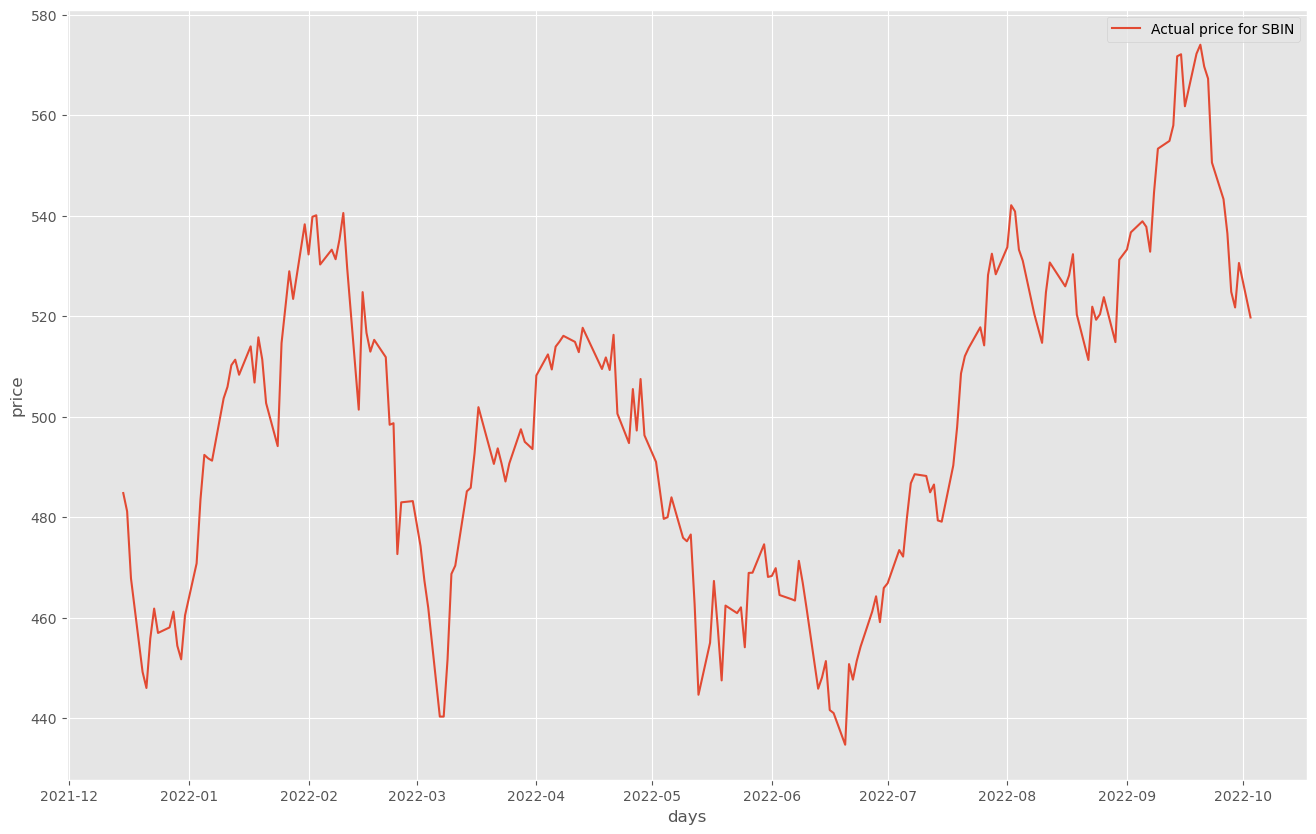

In [15]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [16]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [17]:
init_df

,close,date,scaled_close
Date,,,
2020-01-01,334.45,2020-01-01,0.433837
2020-01-02,339.30,2020-01-02,0.445298
2020-01-03,333.70,2020-01-03,0.432065
2020-01-06,319.00,2020-01-06,0.397330
2020-01-07,318.40,2020-01-07,0.395912
...,...,...,...
2022-09-27,536.50,2022-09-27,0.911271
2022-09-28,524.85,2022-09-28,0.883743
2022-09-29,521.75,2022-09-29,0.876418


In [18]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3) # 3 days

In [20]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

In [22]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

SBIN prediction for upcoming 3 days (527.21$, 507.74$, 524.66$)


In [23]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

22/22 [==============================] - 0s 2ms/step


In [24]:
copy_df

,close,date,scaled_close,predicted_close
Date,,,,
2020-01-01,334.45,2020-01-01,0.433837,328.000000
2020-01-02,339.30,2020-01-02,0.445298,324.250000
2020-01-03,333.70,2020-01-03,0.432065,323.300000
2020-01-06,319.00,2020-01-06,0.397330,318.000000
2020-01-07,318.40,2020-01-07,0.395912,314.000000
...,...,...,...,...
2022-09-27,536.50,2022-09-27,0.911271,541.317810
2022-09-28,524.85,2022-09-28,0.883743,531.885254
2022-09-29,521.75,2022-09-29,0.876418,521.750000


In [26]:
import pandas as pd

In [27]:
# Add predicted results to the table
date_now = pd.to_datetime('2022-10-04')
date_tomorrow = date_now + dt.timedelta(days=1)
date_after_tomorrow = date_now + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

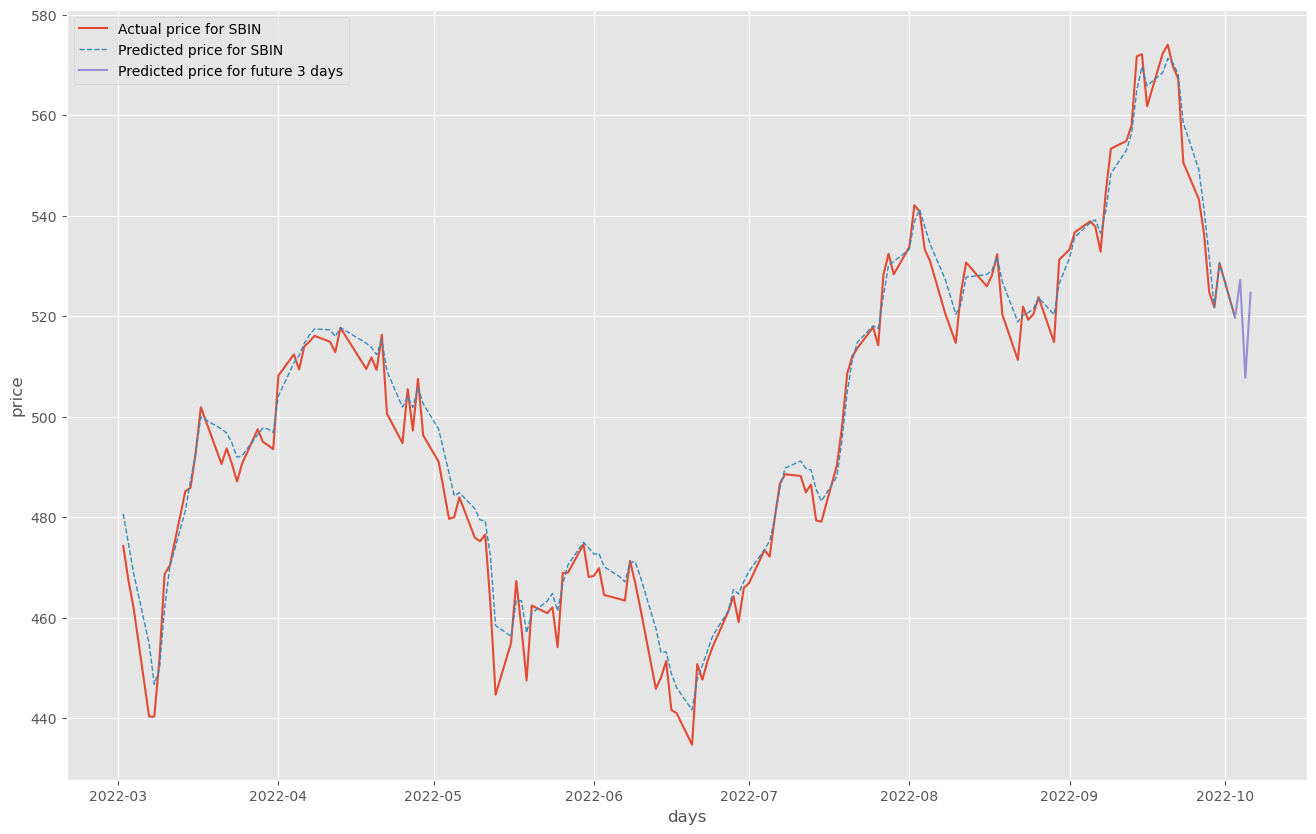

In [28]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()